<a href="https://github.com/geonextgis/eo-stac/intro_to_stac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# The STAC API Workflow

**Author:** Krishnagopal Halder

**Objective:** Learn to Search, Stream, and Download satellite imagery using Python and the STAC [(SpatioTemporal Asset Catalog)](https://stacspec.org/en/) standard.

**What you will learn**
1. **Discovery:** How to find specific satellite scenes without downloading them.

2. **Cloud-Native Analysis:** How to stream pixels directly to RAM for immediate analysis (NDVI).

3. **Bulk Download:** How to download raw files to disk for archival purposes.

## Step 1: Setup & Installation

In [1]:
# Install necessary libraries
# !pip install pystac-client odc-stac rioxarray pandas matplotlib netCDF4

In [2]:
import pystac_client
from odc.stac import load
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray
import os

## Step 2: Discovery (The Search)
We will search the [Earth Search v1 (AWS)](https://stacindex.org/catalogs/earth-search#/) catalog. This is a public API that indexes free data like Sentinel-2 and Landsat.

**Concept:** At this stage, we are only querying Metadata (JSON). We are filtering the library catalog to find the "books" we want.

In [3]:
# Connect to the STAC Catalog
API_URL = "https://earth-search.aws.element84.com/v1/"
client = pystac_client.Client.open(API_URL)

# Get the collections available
collections = client.get_collections()

for col in collections:
    print(col.id, ":", col.title)

sentinel-2-pre-c1-l2a : Sentinel-2 Pre-Collection 1 Level-2A 
cop-dem-glo-30 : Copernicus DEM GLO-30
naip : NAIP: National Agriculture Imagery Program
cop-dem-glo-90 : Copernicus DEM GLO-90
landsat-c2-l2 : Landsat Collection 2 Level-2
sentinel-2-l2a : Sentinel-2 Level-2A
sentinel-2-l1c : Sentinel-2 Level-1C
sentinel-2-c1-l2a : Sentinel-2 Collection 1 Level-2A
sentinel-1-grd : Sentinel-1 Level-1C Ground Range Detected (GRD)


In [4]:
# Define Search Parameters
# Region: San Francisco Bay Area
bbox = [-122.55, 37.7, -122.35, 37.85]

# # 3. Define date range
date_range = "2023-06-01/2023-09-30"

# Collection: Sentinel-2 Level 2A (Surface Reflectance)
collection = "sentinel-2-l2a"

# Execute search
search = client.search(
    collections=[collection],
    bbox=bbox,
    datetime=date_range,
    query={"eo:cloud_cover": {"lt": 10}} # Filter: Less than 10% clouds
)

# Check results
items = search.item_collection()
print(f"Found {len(items)} scenes matching your criteria.")

# Peek at the first item found
first_item = items[0]
print(f"Example Item ID: {first_item.id}")
print(f"Captured on: {first_item.datetime.date()}")

Found 3 scenes matching your criteria.
Example Item ID: S2B_10SEG_20230921_0_L2A
Captured on: 2023-09-21


**Understanding "Assets"**

A single STAC Item (one scene) contains multiple Assets. These are the actual files. Let's look at what is inside one item.

In [5]:
# Display the available assets for the first item
assets_df = pd.DataFrame.from_dict(first_item.assets, orient='index').reset_index()
assets_df.columns = ['asset', 'href']
print(assets_df.shape)
assets_df.head()

(35, 2)


,asset,href
0,aot,<Asset href=https://sentinel-cogs.s3.us-west-2...
1,blue,<Asset href=https://sentinel-cogs.s3.us-west-2...
2,coastal,<Asset href=https://sentinel-cogs.s3.us-west-2...
3,granule_metadata,<Asset href=https://sentinel-cogs.s3.us-west-2...
4,green,<Asset href=https://sentinel-cogs.s3.us-west-2...


## Step 2: Cloud-Native Analysis (Streaming)
**The Modern Workflow:** instead of downloading the files shown above, we use Cloud Optimized GeoTIFFs (COGs). We can stream just the pixels inside our bounding box directly into an xarray DataArray.

**Goal:** Calculate NDVI (Normalized Difference Vegetation Index) for vegetation health.

In [6]:
# Load Data into Memory (Lazy Loading)
# We request only the Red and Near-Infrared (NIR) bands needed for NDVI
data = load(
    items,
    bands=['red', 'nir'],
    bbox=bbox,
    resolution=10,                      # Sentinel-2 resolution is 10m
    group_by='solar_day',               # Combine segments from the same day,
    chunks={'x': 2048, 'y': 2048}       # Use Dask for parallel processing
)

print("Data Cube Structure (No pixels downloaded yet):")
data

Data Cube Structure (No pixels downloaded yet):


<xarray.Dataset> Size: 36MB
Dimensions:      (y: 1676, x: 1773, time: 3)
Coordinates:
  * y            (y) float64 13kB 4.189e+06 4.189e+06 ... 4.173e+06 4.173e+06
  * x            (x) float64 14kB 5.396e+05 5.396e+05 ... 5.573e+05 5.573e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 24B 2023-06-18T19:04:13.751000 ... 202...
Data variables:
    red          (time, y, x) uint16 18MB dask.array<chunksize=(1, 1676, 1773), meta=np.ndarray>
    nir          (time, y, x) uint16 18MB dask.array<chunksize=(1, 1676, 1773), meta=np.ndarray>

Streaming pixels and plotting... this may take 10-20 seconds.


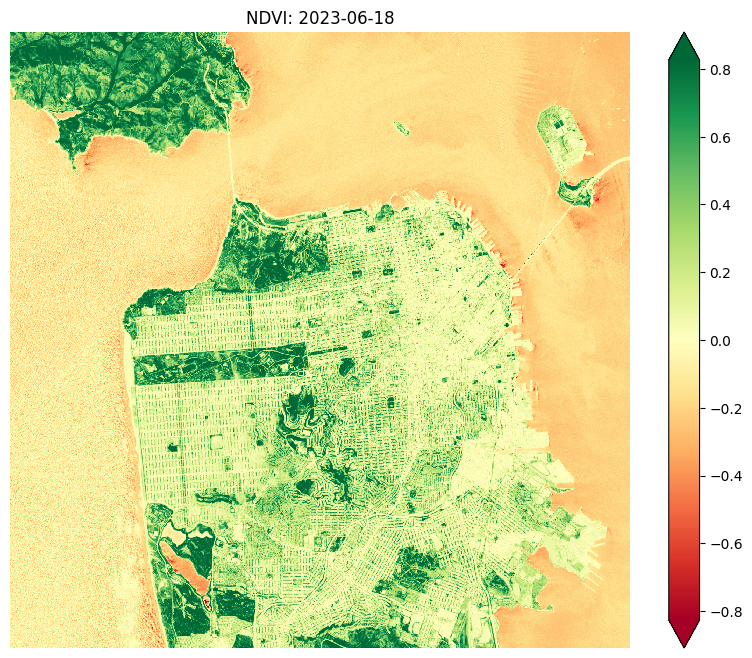

In [7]:
# Apply scale factor
data = data / 1e4

# Perform Math (NDVI Calculation)
# Formula: (NIR - Red) / (NIR + Red)
ndvi = (data.nir - data.red) / (data.nir + data.red)

# Compute and visualize
# We select the first time step available in our search
print("Streaming pixels and plotting... this may take 10-20 seconds.")
ndvi_snapshot = ndvi.isel(time=0).compute()

plt.figure(figsize=(10, 8))
ndvi_snapshot.plot.imshow(cmap='RdYlGn', robust=True)
plt.title(f"NDVI: {data.time[0].dt.date.item()}")
plt.axis("off")
plt.show()

## Step 3: Download the Data

In [8]:
# Save the Single Snapshot as a GeoTIFF
# Ensure the CRS (Coordinate Reference System) is written to the metadata
ndvi_snapshot.rio.write_crs(data.spatial_ref.item(), inplace=True)

# Save to disk
ndvi_snapshot.rio.to_raster('ndvi_snapshot.tif')
print("Saved ndvi_snapshot.tif successfully")

# Save the whole Time-Series as NetCDF
ndvi.rio.write_crs(data.spatial_ref.item(), inplace=True)
ndvi.to_netcdf('ndvi_timeseries.nc', engine="netcdf4")
print('Saved ndvi_timeseries.nc successfuly!')

Saved ndvi_snapshot.tif successfully
Saved ndvi_timeseries.nc successfuly!
